# Numerical Results for the Gene Expression Network

### Compare Gillespie simulation with mass action kinetics and Plefka approximation

In [1]:
using CRN
using PyPlot
PyPlot.PyDict(PyPlot.matplotlib."rcParams")["font.size"] = 16

16

In [2]:
function Gene_params()
    # Parameters
    num_species = 3     # number of species
    num_int = 3         # number of interaction reaction

    # Reaction constants
    k1 = [8.0, 8.0, 3.0]    # Creation
    k2 = [3.0, 2.0, 1.5]    # Annihiliation
    k3 = [0.5, 0.3, 0.4]    # Interaction
    k = [k1, k2, k3]

    # Stoichiometric
    s_i = zeros(Int, num_int, num_species)
    r_i = copy(s_i)
    s_i[1,:] = [1 1 0]
    r_i[1,:] = [1 0 0]
    s_i[2,:] = [0 0 1]
    r_i[2,:] = [1 1 0]
    s_i[3,:] = [1 1 0]
    r_i[3,:] = [0 0 1]

    # Times
    t_init = 0.0        # Start time
    t_final = 5.0       # End time
    delta_t = 0.01      # time step

    # Initial condition
    x0 = [4., 3., 2.]

    return Parameters(x0, k, s_i, r_i, t_init, t_final, delta_t)
end
p = Gene_params()
ts = tspan(p);

## Gillespie Simulation

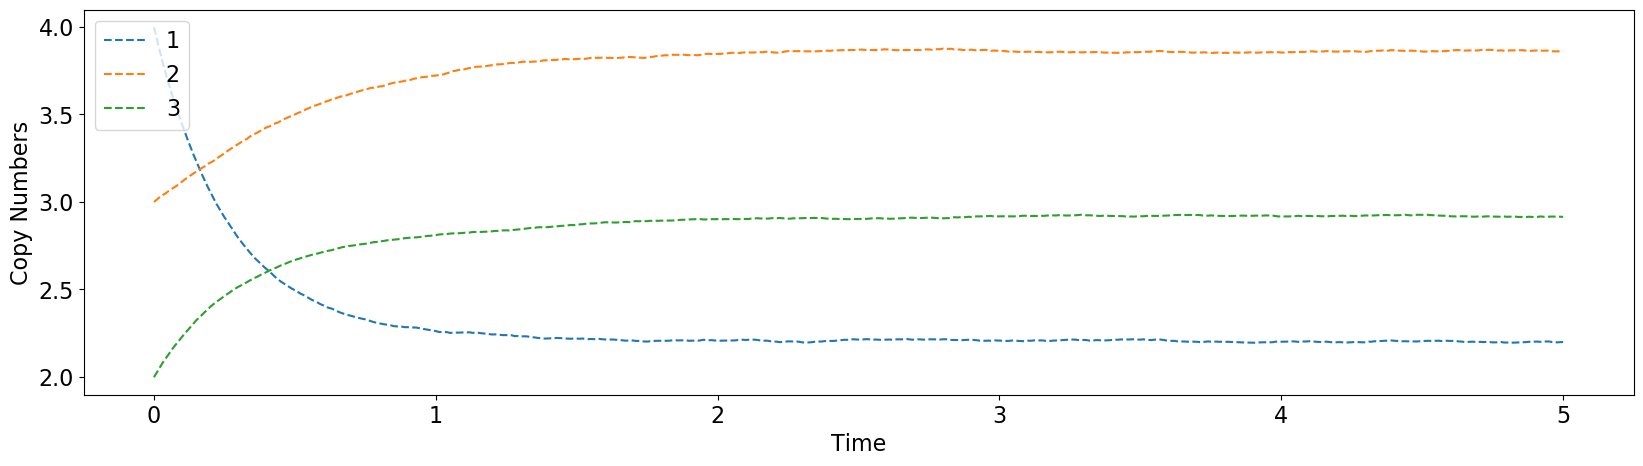

PyObject Text(32.999999999999986, 0.5, 'Copy Numbers')

In [3]:
N = 100000   # Repititions
res_gil = gillespie_avg(p.x0, p.k, p.s_i, p.r_i, ts, N)
plot_trajectories(res_gil)

## Mass Action Kinetics

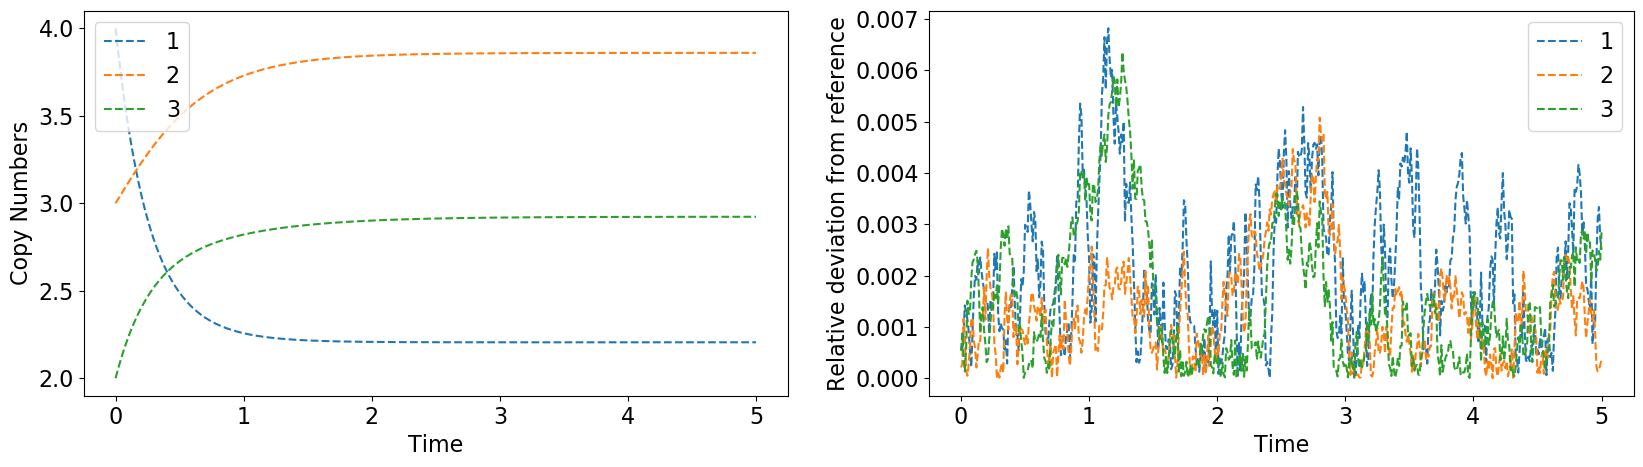

PyObject Text(850.2045454545454, 0.5, 'Relative deviation from reference')

In [4]:
function f_massAction!(du,u,k,t)
    du[1] = k[1][1] - k[2][1]*u[1] - k[3][2]*u[1]*u[2] + k[3][3]*u[3]
    du[2] = k[1][2] - k[2][2]*u[2] + k[3][1]*u[1] - k[3][2]*u[1]*u[2] + k[3][3]*u[3]
    du[3] = k[1][3] - k[2][3]*u[3] + k[3][2]*u[1]*u[2] - k[3][3]*u[3]
end

tsp = (ts[1], ts[end])
res_ma = ode_solver(f_massAction!, p.k, tsp, p.delta_t, p.x0)
plot_trajectories_and_deviation(res_ma, res_gil)

## Plefka with linear O.P. and power α¹ 

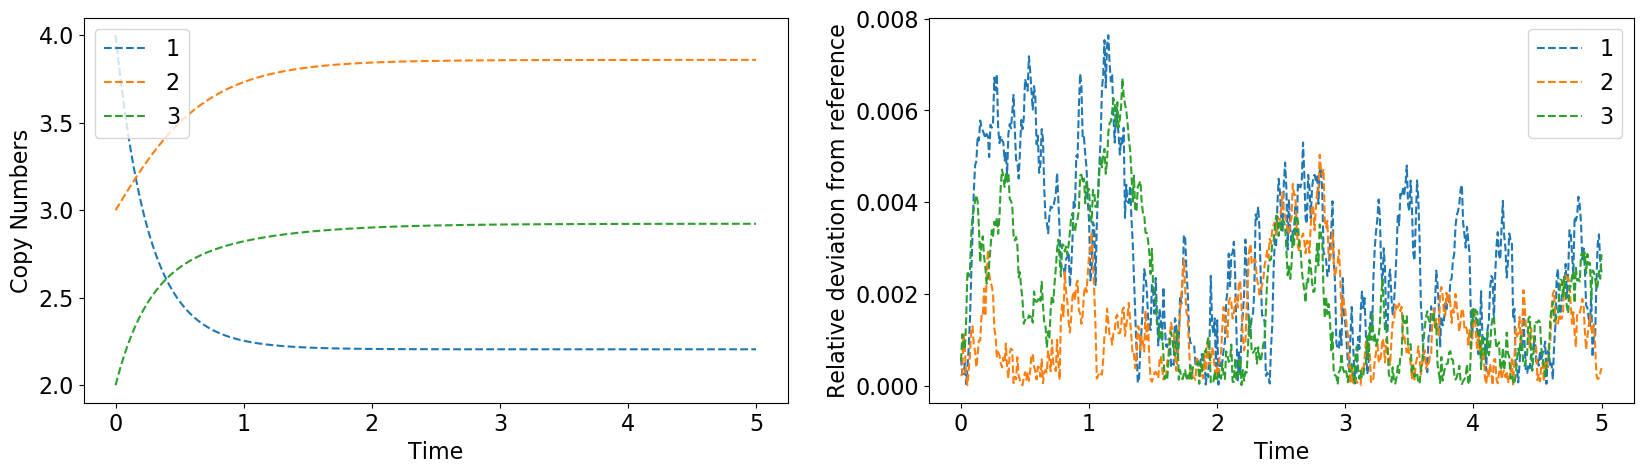

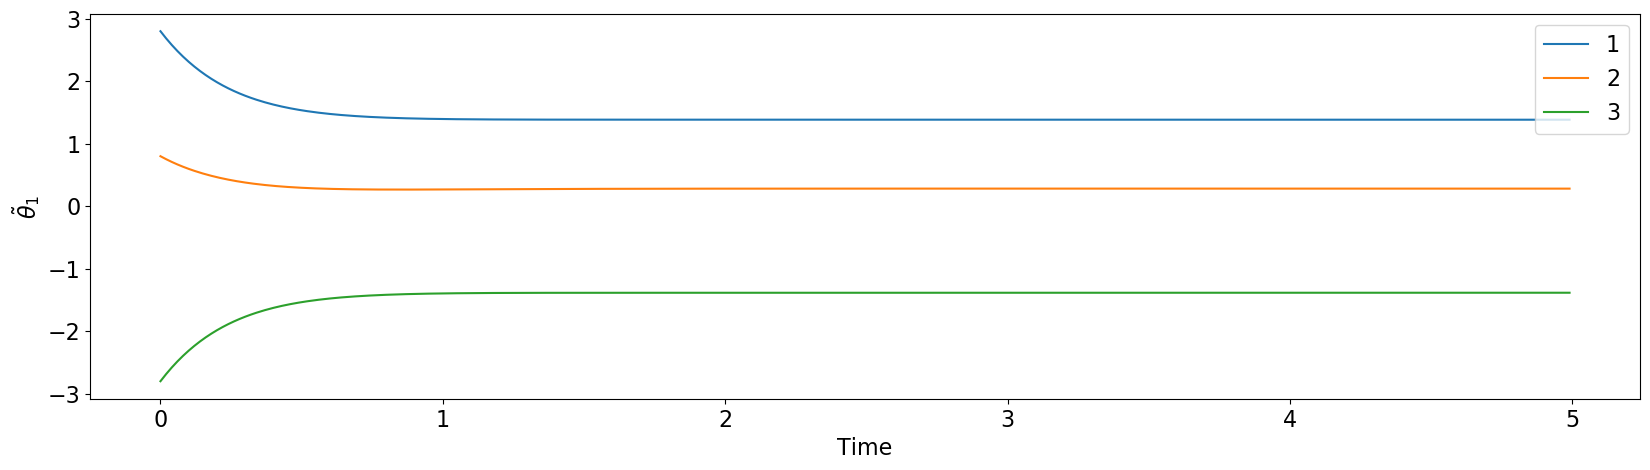

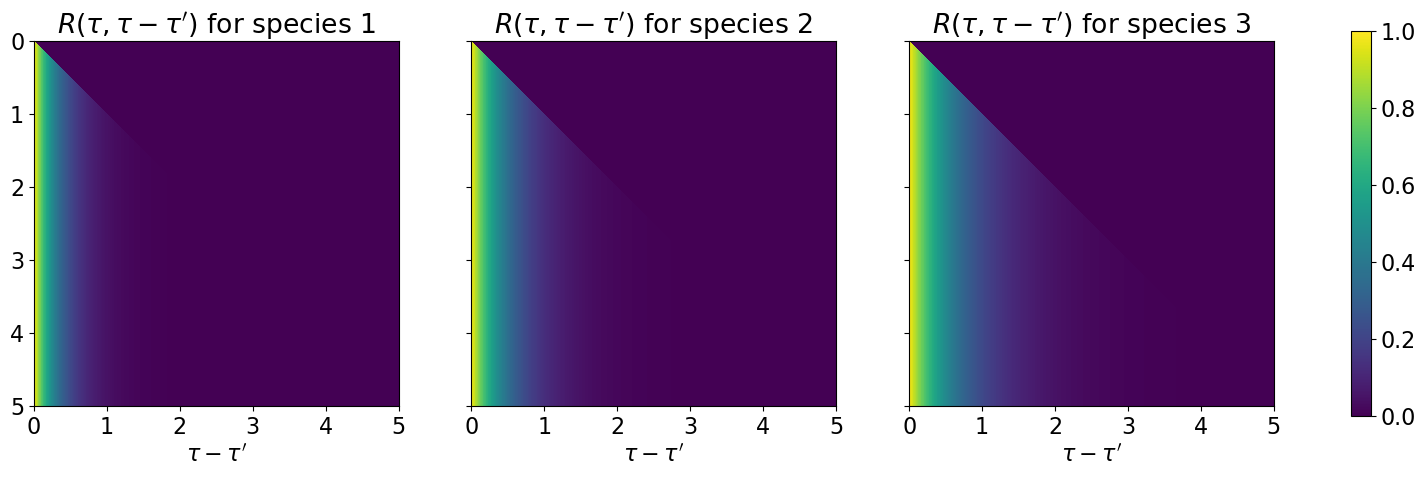

In [5]:
plf_sim_11 = Plefka(1.0, 1, "linear") # α, alphaOrder, orderParameter
res_plf_11 = euler_step(p.x0, p.k, ts, plf_sim_11, p.s_i, p.r_i)
plot_trajectories_and_deviation(res_plf_11[1], res_gil)
plot_hatTheta(ts, res_plf_11[3])
plot_responses(res_plf_11[2])

## Plefka with linear O.P. and power α²

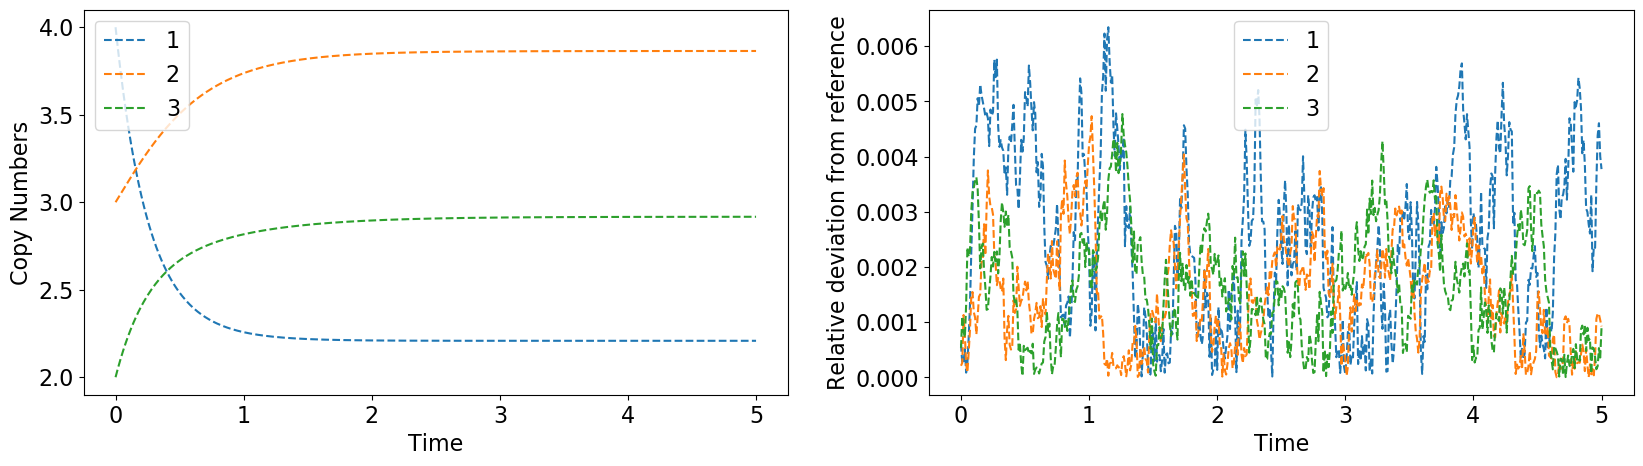

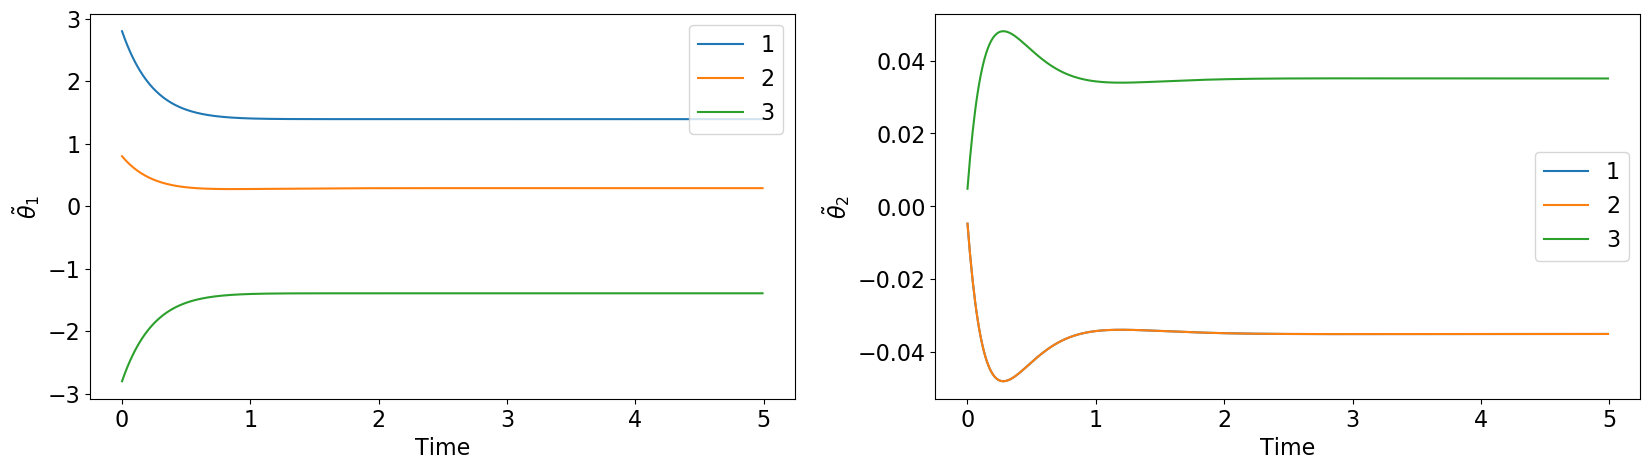

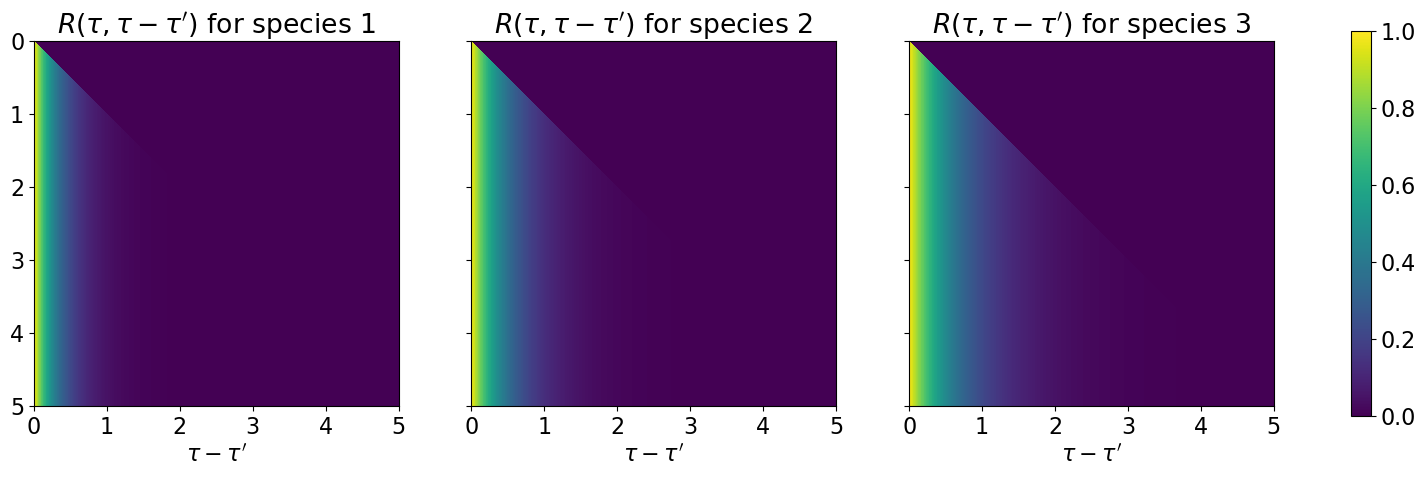

In [6]:
plf_sim_21 = Plefka(1.0, 2, "linear") # α, alphaOrder, orderParameter
res_plf_21 = euler_step(p.x0, p.k, ts, plf_sim_21, p.s_i, p.r_i)
plot_trajectories_and_deviation(res_plf_21[1], res_gil)
plot_hatTheta(ts, res_plf_21[3])
plot_responses(res_plf_21[2])

## Plefka with quad O.P. and power α¹ 

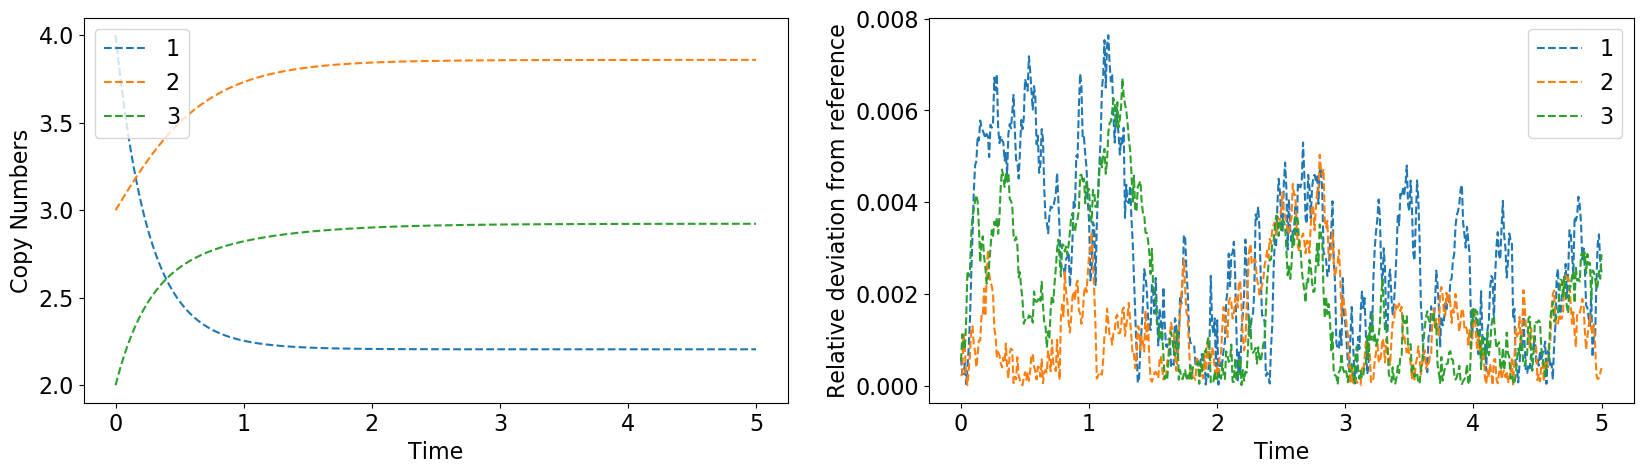

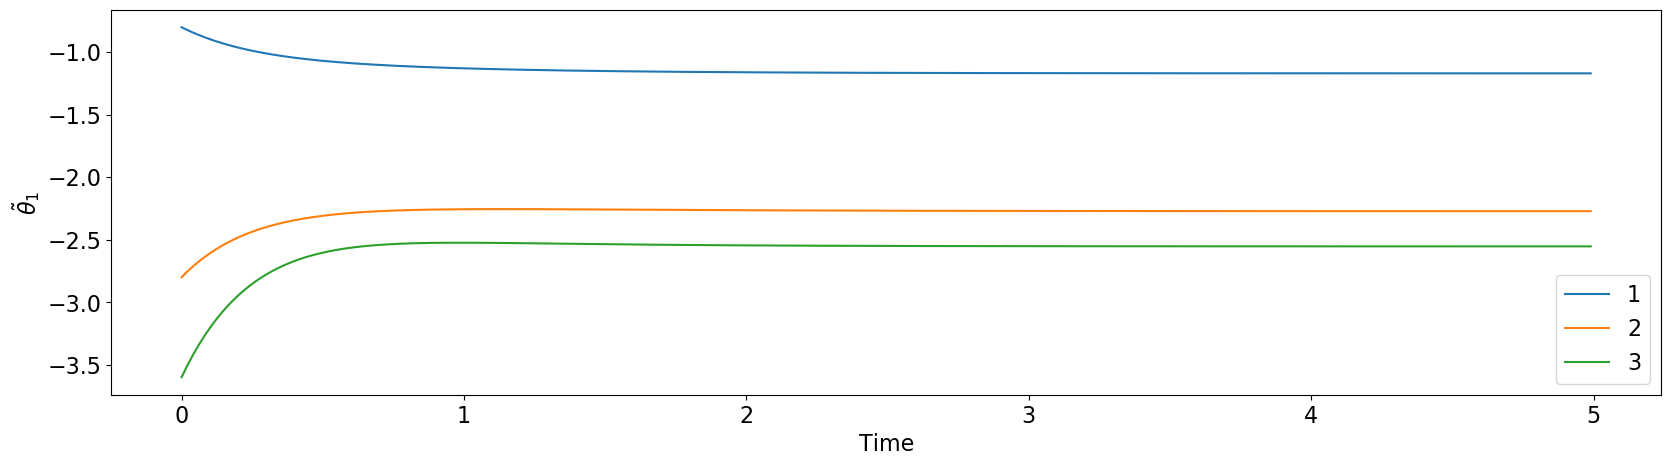

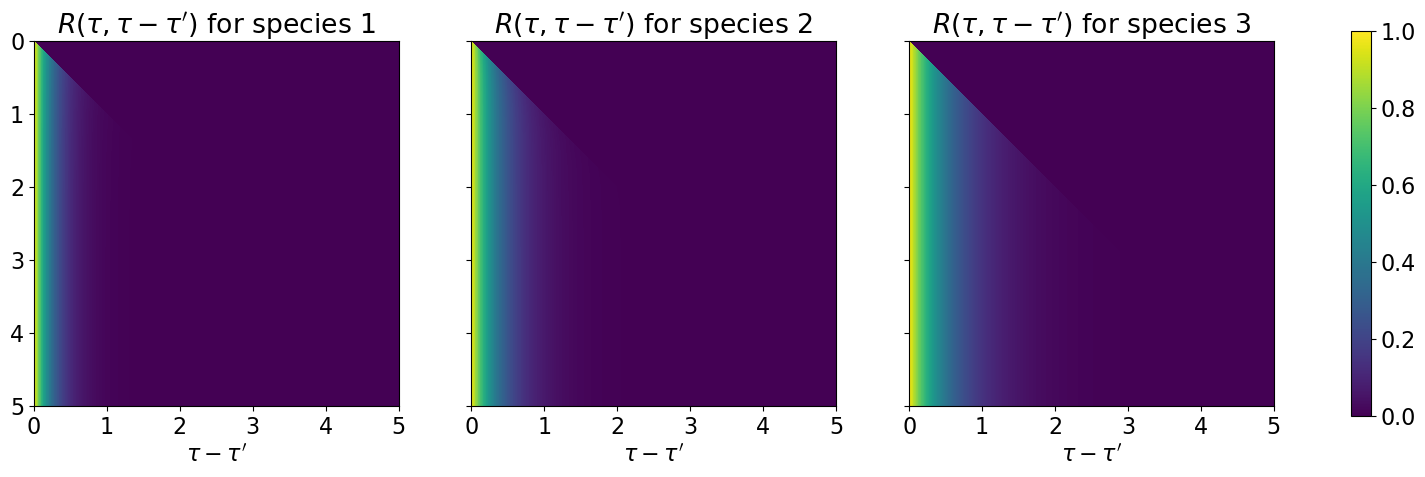

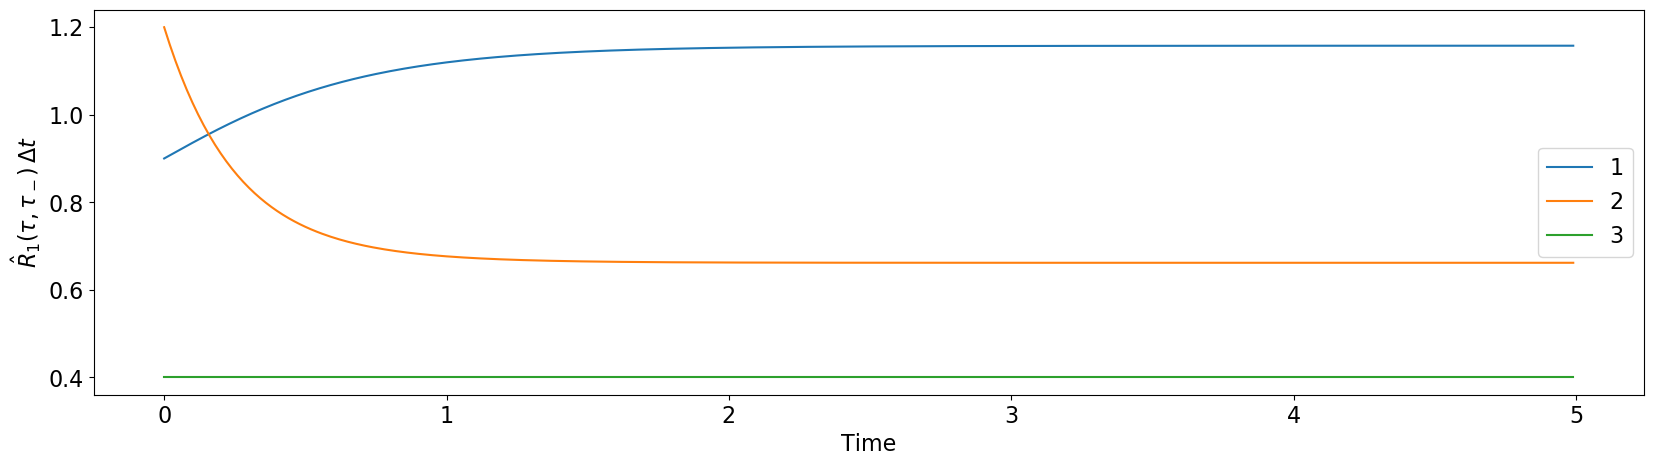

PyObject Text(43.17777777777776, 0.5, '$\\hat{R}_1(\\tau,\\tau_-)\\,\\Delta t$')

In [7]:
plf_sim_12 = Plefka(1.0, 1, "quad") # α, alphaOrder, orderParameter
res_plf_12 = euler_step(p.x0, p.k, ts, plf_sim_12, p.s_i, p.r_i)
plot_trajectories_and_deviation(res_plf_12[1], res_gil)
plot_hatTheta(ts, res_plf_12[3])
plot_responses(res_plf_12[2])
plot_hatR_diag(ts, res_plf_12[3])

## Plefka with quad O.P. and power α²

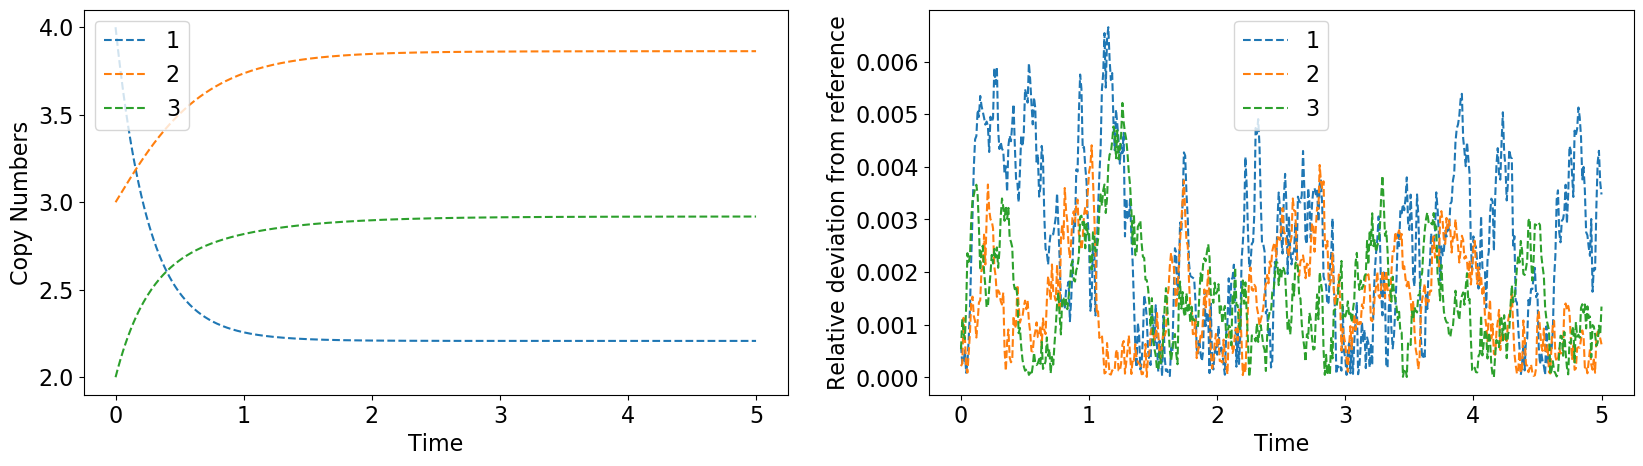

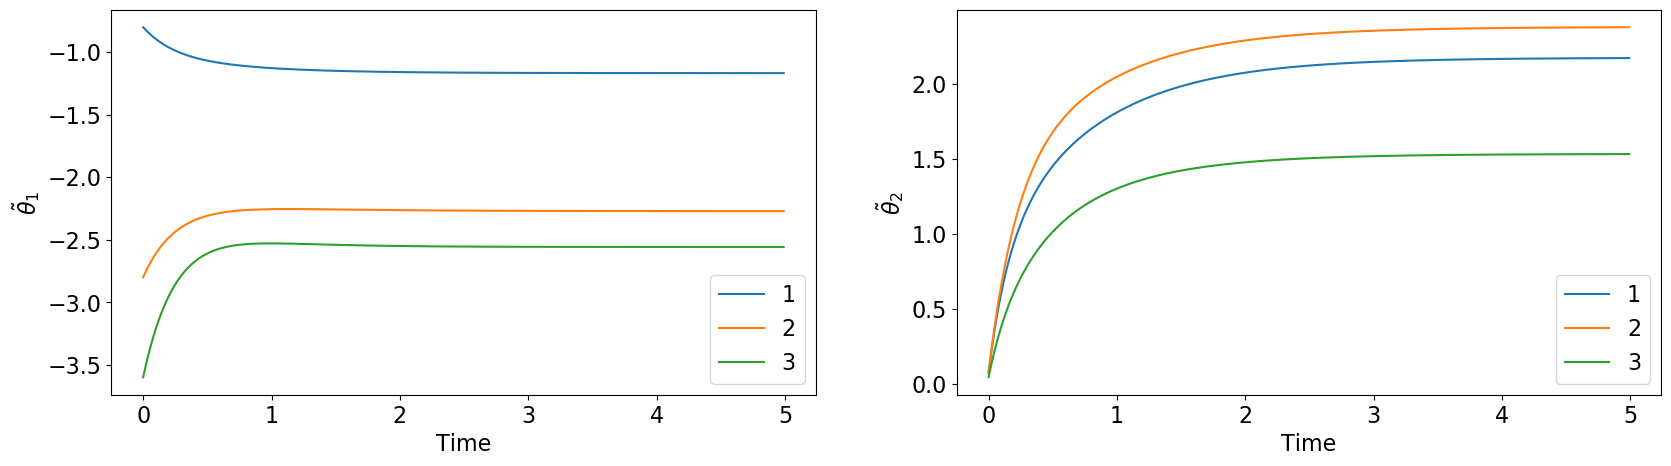

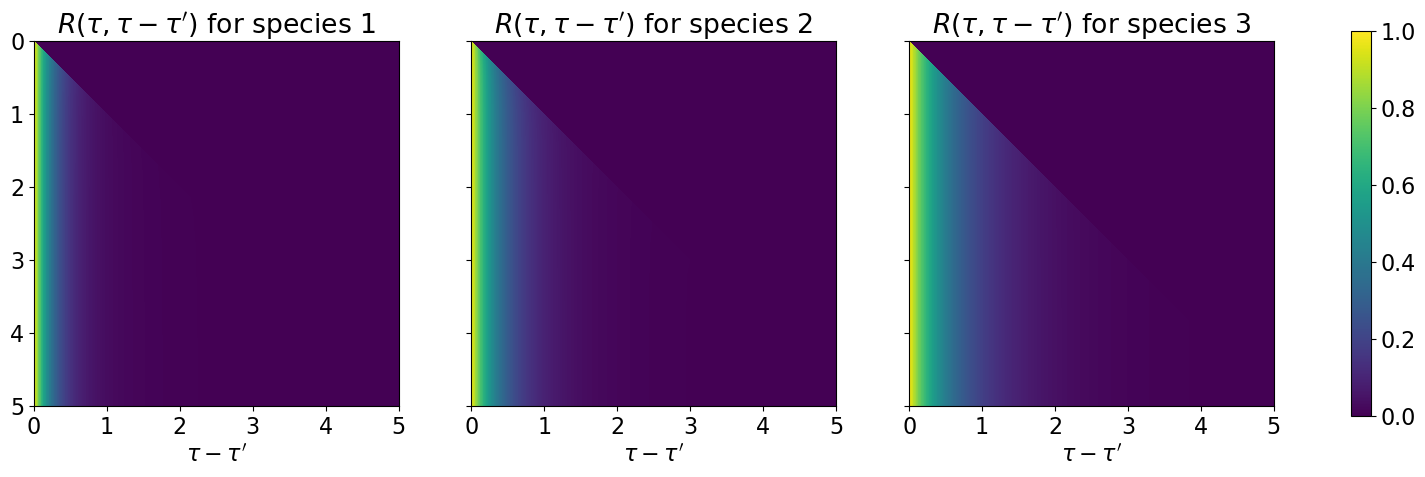

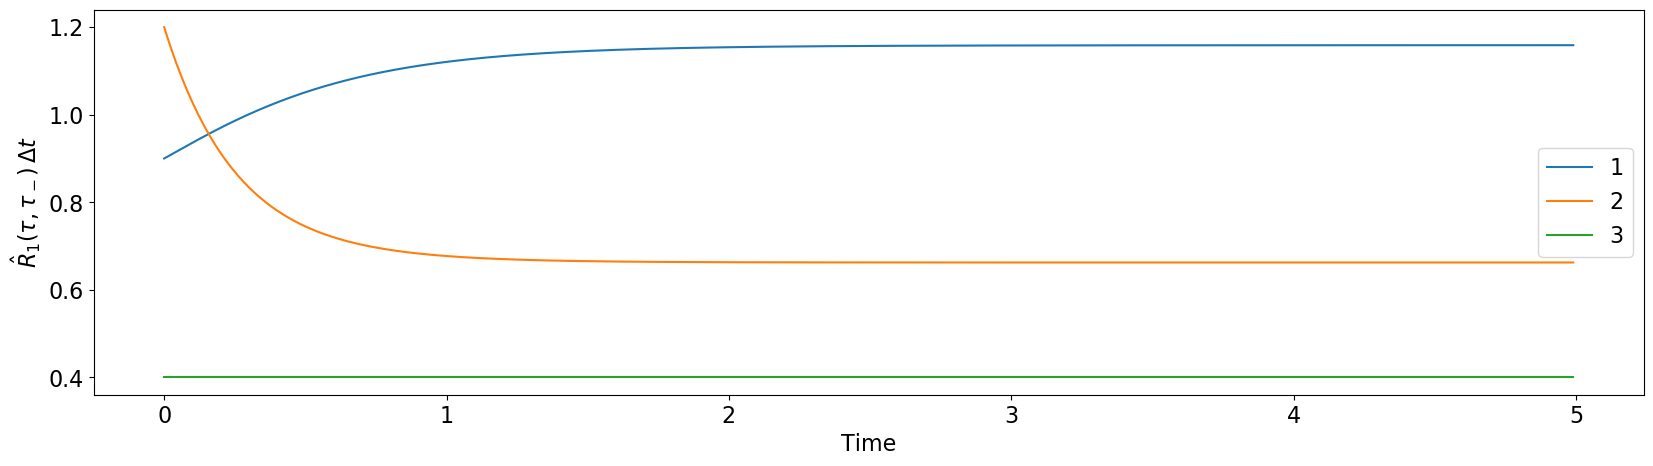

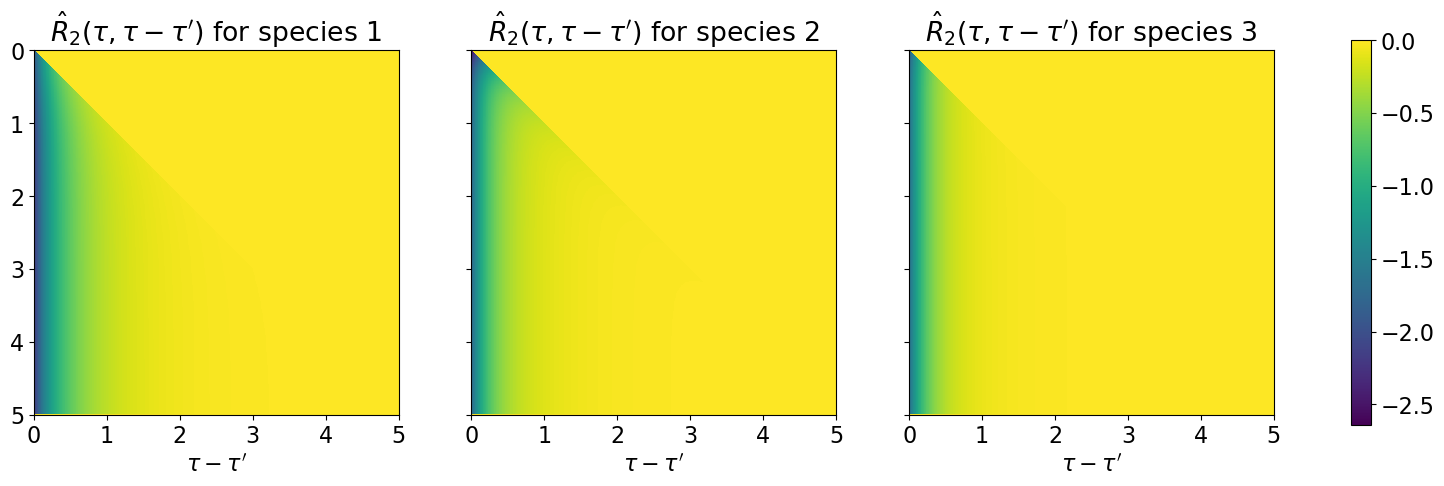

In [8]:
plf_sim_22 = Plefka(1.0, 2, "quad") # α, alphaOrder, orderParameter
res_plf_22 = euler_step(p.x0, p.k, ts, plf_sim_22, p.s_i, p.r_i)
plot_trajectories_and_deviation(res_plf_22[1], res_gil)
plot_hatTheta(ts, res_plf_22[3])
plot_responses(res_plf_22[2])
plot_hatR_diag(ts, res_plf_22[3])
plot_hatR(ts, res_plf_22[3])

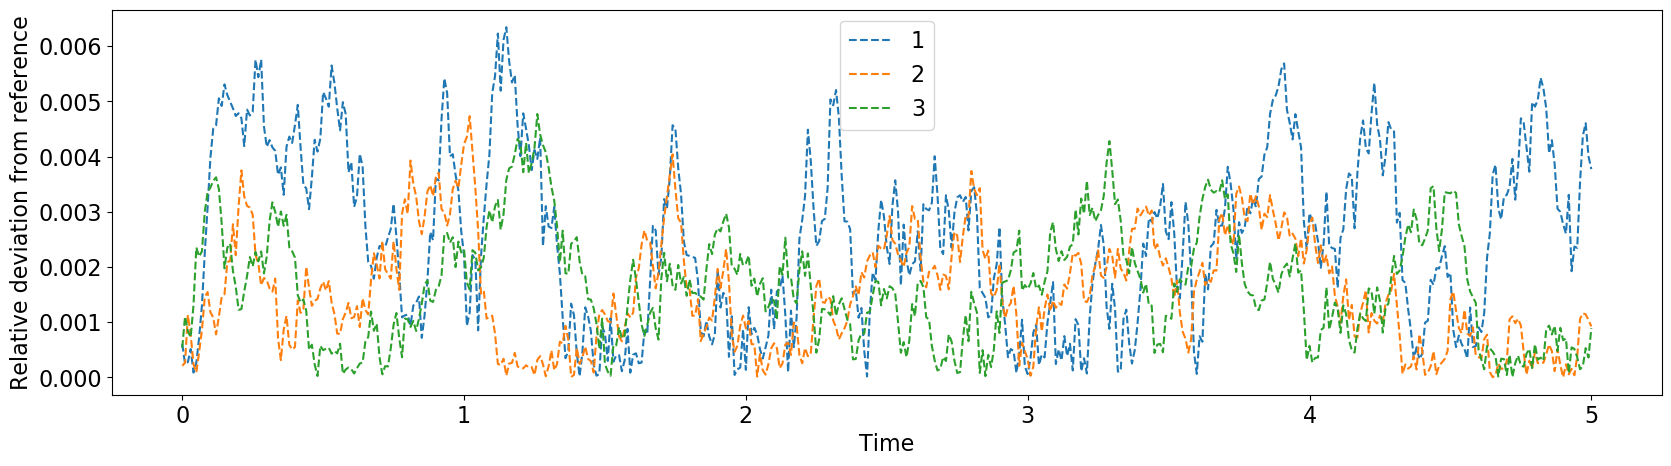

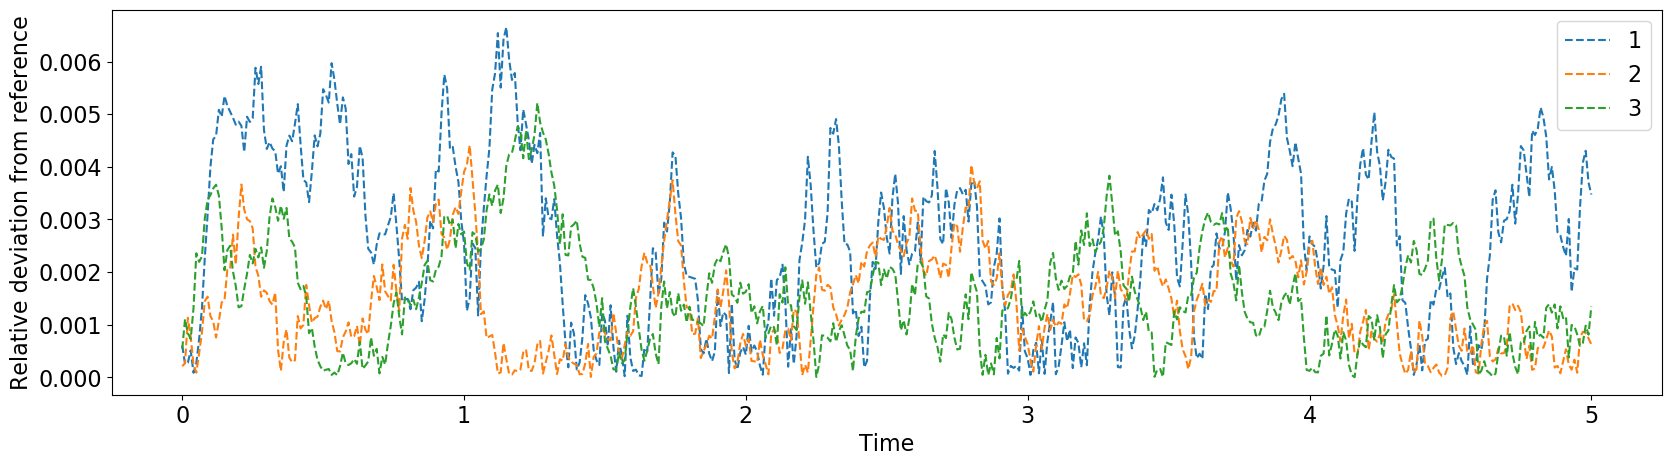

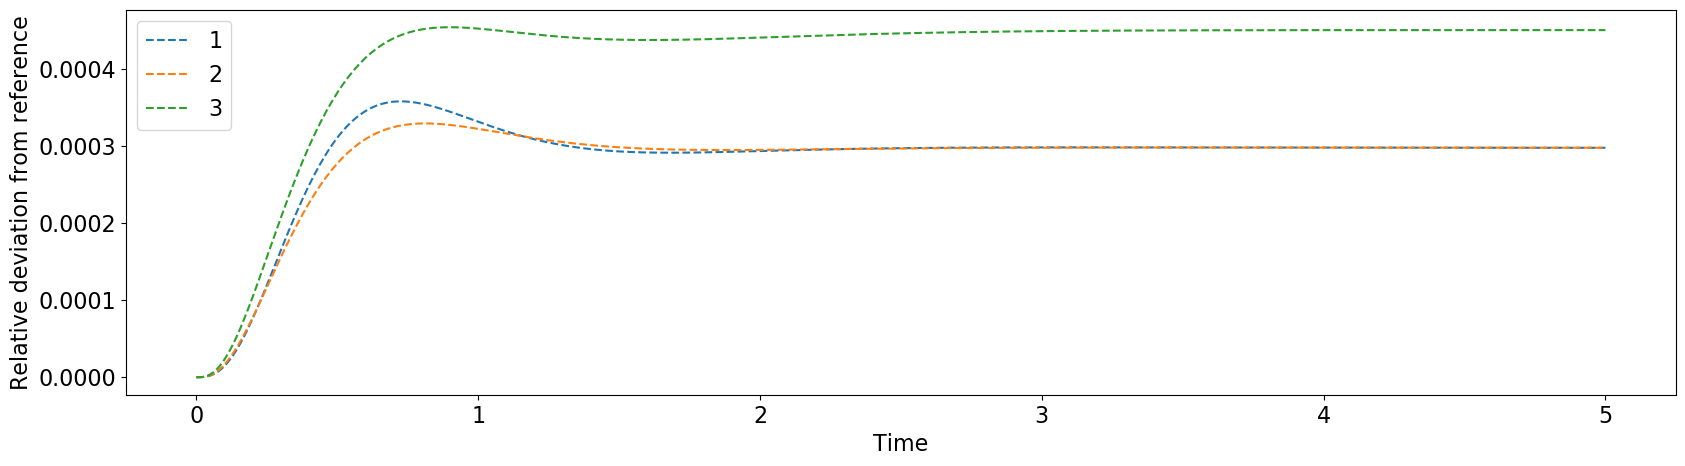

PyObject Text(33.0, 0.5, 'Relative deviation from reference')

In [9]:
plot_deviation(res_plf_21[1], res_gil)
plot_deviation(res_plf_22[1], res_gil)
plot_deviation(res_plf_21[1], res_plf_22[1])